In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
class remove_outlier(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        X_martix = X.select_dtypes(include = np.number).describe()
        self.values = X_martix.loc[['25%','50%','75%']]
        self.up = self.values.loc['75%'] + 1.5*(self.values.loc['75%'] - self.values.loc['25%'])
        self.down = self.values.loc['25%'] - 1.5*(self.values.loc['75%'] - self.values.loc['25%'])
        return self
    def transform(self, X, y = None):
        for feature in self.values.columns:
            X = X[(X[feature] < self.up[feature]) & (X[feature] > self.down[feature])]
        return X

In [3]:
dataset1 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_19_7(preprocessed).csv')
dataset2 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_20_6A(preprocessed).csv')
dataset3 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_20a_7(preprocessed).csv')
dataset4 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_24a_6(preprocessed).csv')
dataset5 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_24a_7(preprocessed).csv')
dataset6 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_20_1(preprocessed).csv')
dataset7 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_20_1Z(preprocessed).csv')
dataset8 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_20_2(preprocessed).csv')
dataset9 = pd.read_csv('Sources/data/labels/permeability/preprocessed_data/204_20_3(preprocessed).csv')

combined_dataset = pd.concat([dataset1,  dataset2, dataset3, dataset4, dataset5, dataset6, dataset7, dataset9], ignore_index=True)
combined_dataset = combined_dataset.drop_duplicates()
combined_dataset.describe()
space_index = combined_dataset[pd.to_numeric(combined_dataset['PERMEABILITY (HORIZONTAL)\nKair\nmd'],errors='coerce').notnull()].index
# new_df = pd.concat([combined_dataset.iloc[:315], combined_dataset.iloc[329:]], ignore_index=True)

new_df = combined_dataset.loc[space_index]

y = new_df['PERMEABILITY (HORIZONTAL)\nKair\nmd']
y = y.replace('<.01', '0.0001')
y = y.replace('< .01', '0.0001')
y = y.astype(float)
# y = np.log(y+1e-6)
columns_to_copy = ['true depth', 'PEF','POROSITY\n(HELIUM)', 'DENS', 'DTC', 'GR', 'NEUT',  'RDEP']
X = new_df[columns_to_copy]
porosity = list(X['POROSITY\n(HELIUM)'])
for i, value in enumerate(porosity):
    if not isinstance(value, float):
        result = ''.join(['0' if c.isalpha() else c for c in value])
        result = result.replace(',','.')
        porosity[i] = float(result)

X['POROSITY\n(HELIUM)'] = porosity
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,random_state=42, shuffle=True)
X.duplicated().sum()

/var/folders/31/_my6459n79l7x2jc9c2xyz180000gn/T/ipykernel_20286/3187945523.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['POROSITY\n(HELIUM)'] = porosity


0

<Axes: >

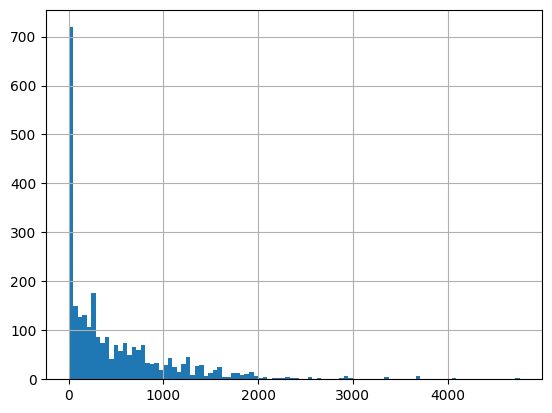

In [4]:
y.hist(bins=100)

In [5]:
X['POROSITY\n(HELIUM)'].isnull().sum()

6

In [6]:
X_train

,true depth,PEF,POROSITY\n(HELIUM),DENS,DTC,GR,NEUT,RDEP
449,2148.5856,2.1300,25.6,2.2302,97.3620,54.0522,0.2706,17.2701
1716,2220.0108,3.3420,26.5,2.3553,105.7883,93.0048,0.3767,2.4645
2558,2674.5956,3.1850,21.4,2.3176,83.5274,60.3987,0.2807,2.6737
2440,2428.3172,2.9422,26.3,2.2465,89.6088,55.3741,0.3059,2.7745
1250,2095.3476,2.7845,30.3,2.1911,104.3406,64.5189,0.3326,30.2867
...,...,...,...,...,...,...,...,...
1673,2211.0192,3.5446,20.9,2.3743,108.5913,85.0591,0.3763,2.2189
1120,2490.1168,3.0258,29.3,2.2800,110.4128,73.0632,0.4163,1.9192
1155,2079.9552,2.5329,28.2,2.2029,100.5417,56.5796,0.3051,65.2279
1319,2110.5876,2.6147,27.0,2.2192,99.8982,55.8864,0.2836,40.6540


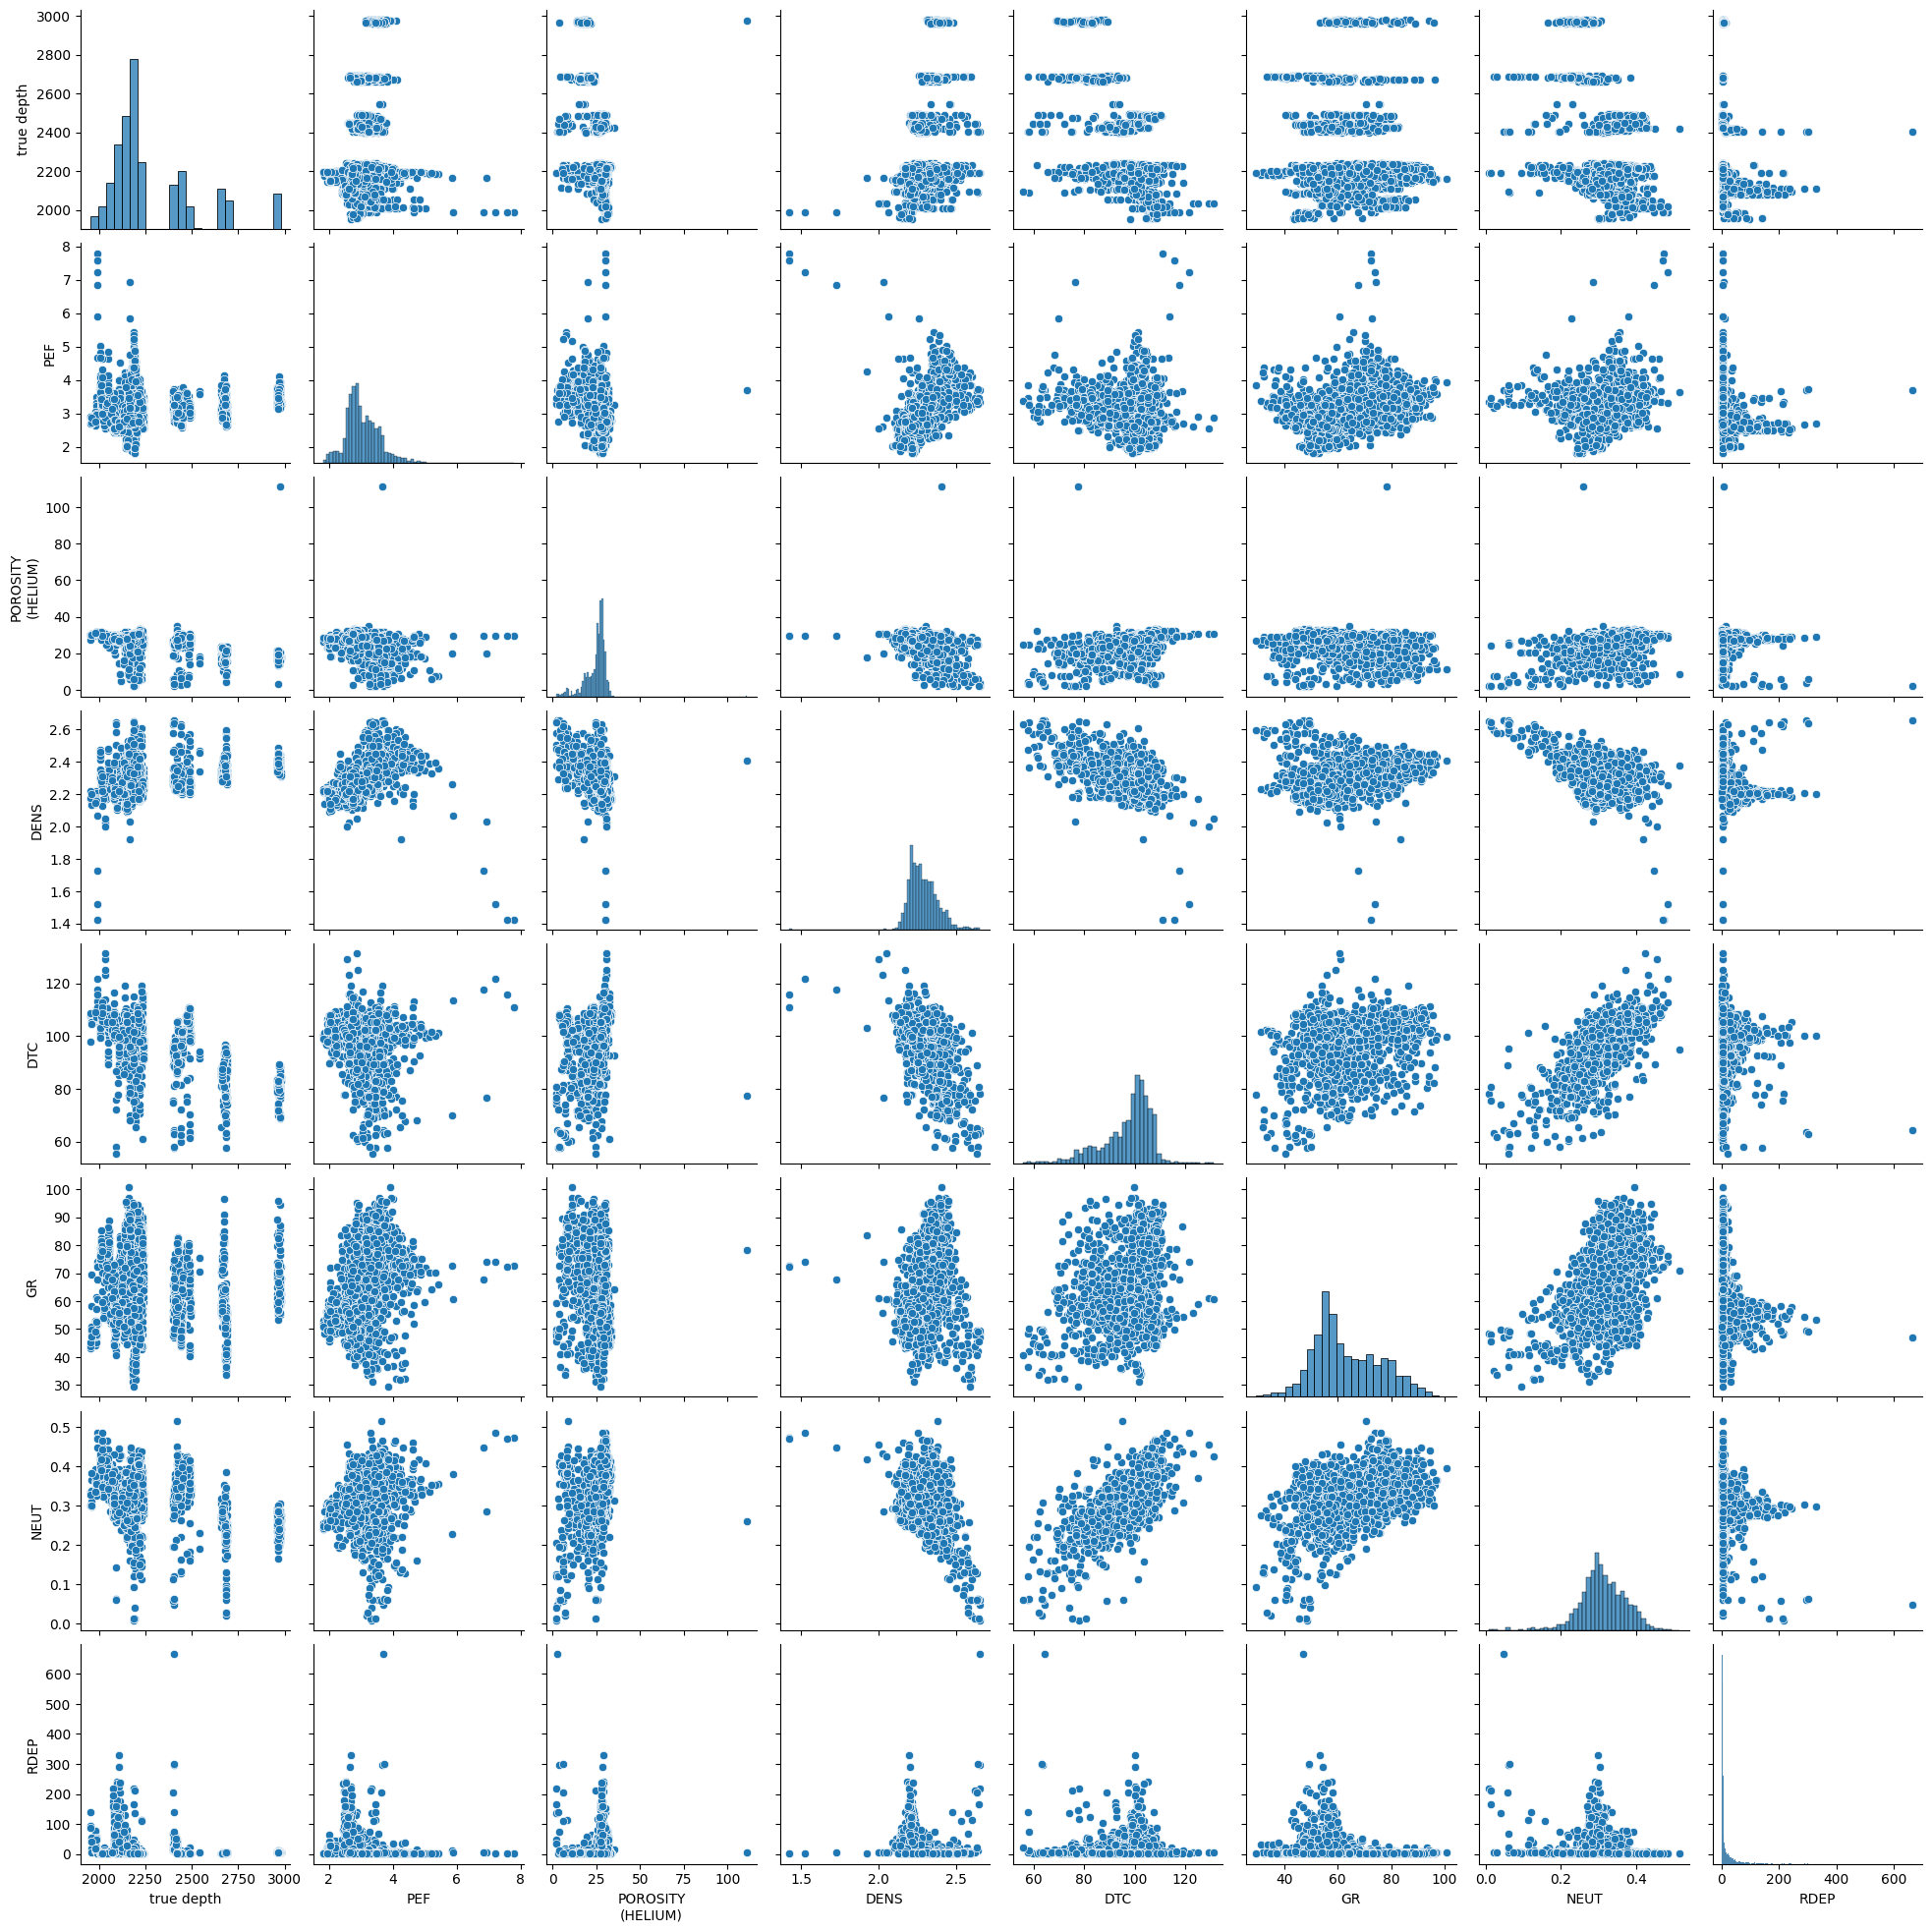

In [7]:
num_data = X_train.select_dtypes(include=['int64','float64']).columns
sns.pairplot(X_train[num_data]);

array([[<Axes: title={'center': 'true depth'}>,
        <Axes: title={'center': 'PEF'}>,
        <Axes: title={'center': 'POROSITY\n(HELIUM)'}>],
       [<Axes: title={'center': 'DENS'}>,
        <Axes: title={'center': 'DTC'}>, <Axes: title={'center': 'GR'}>],
       [<Axes: title={'center': 'NEUT'}>,
        <Axes: title={'center': 'RDEP'}>, <Axes: >]], dtype=object)

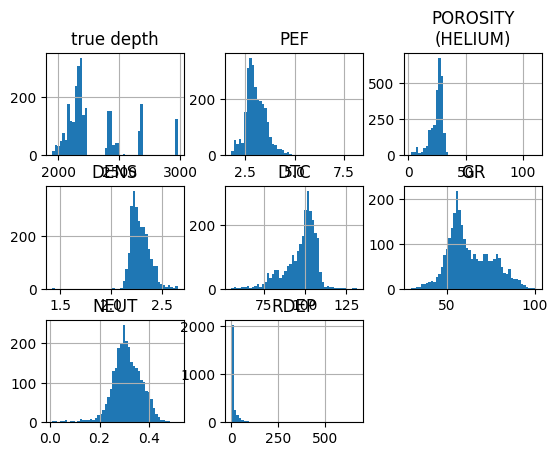

In [8]:
X.hist(bins=50)

<Axes: >

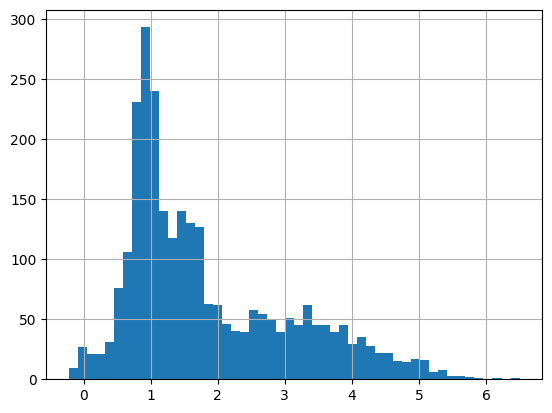

In [9]:
(np.log(X['RDEP'])).hist(bins=50)

<Axes: >

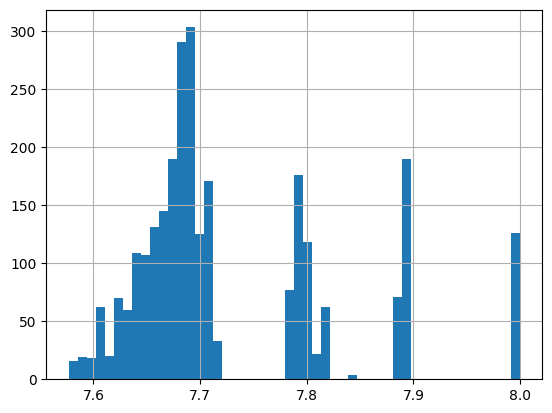

In [10]:
(np.log(X['true depth'])).hist(bins=50)

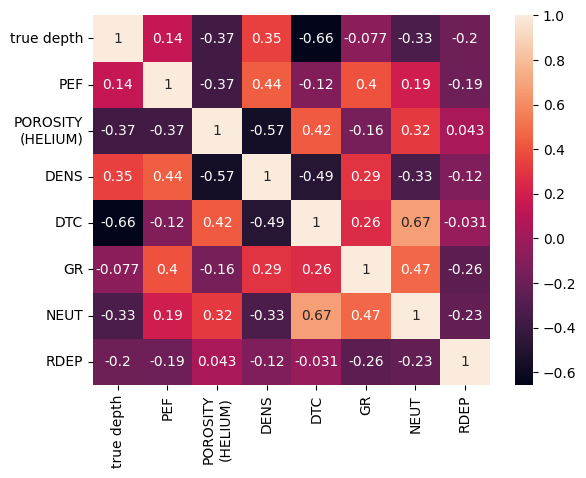

In [11]:
corr = X_train[num_data].corr()
sns.heatmap(corr, annot=corr);

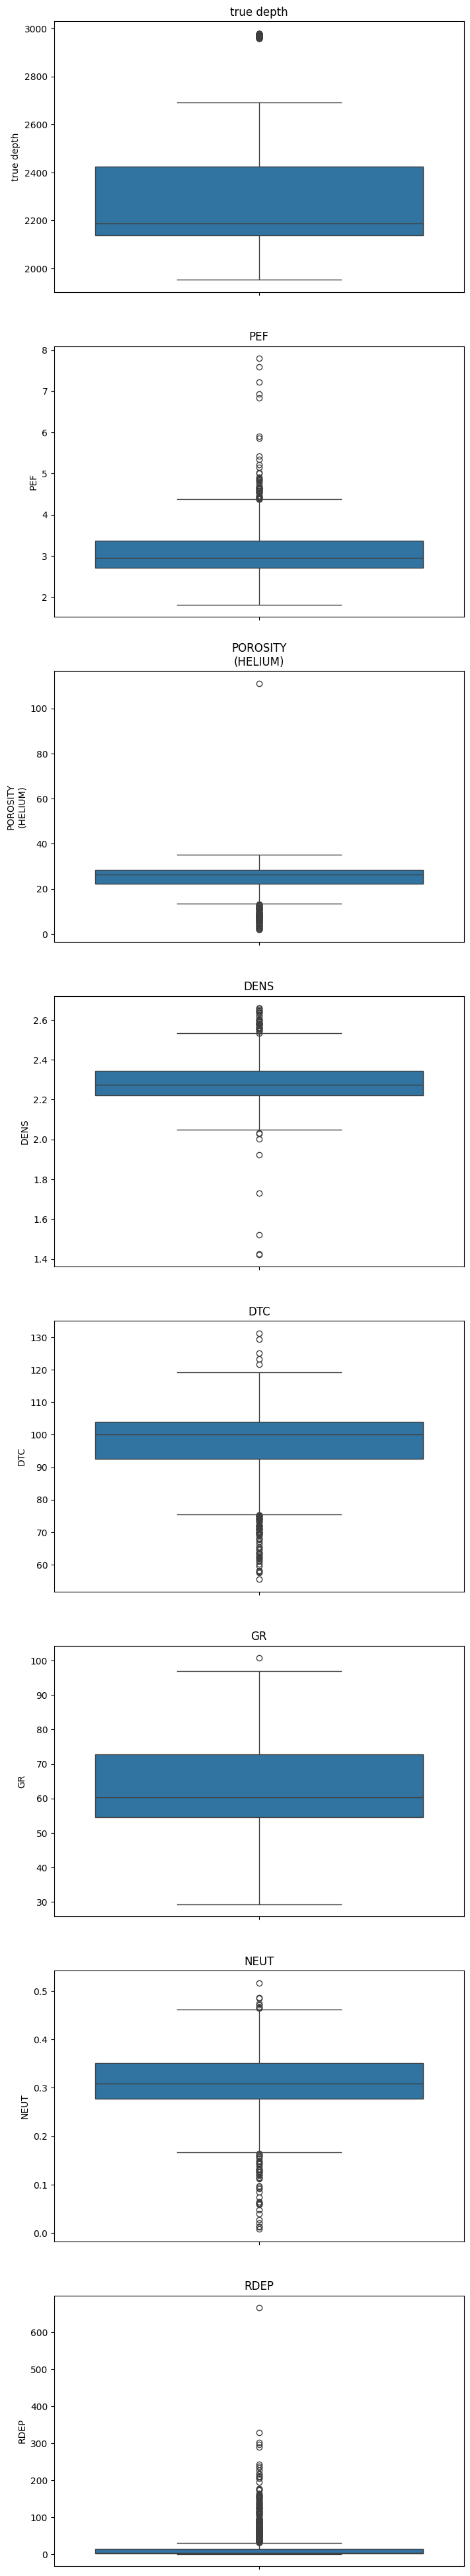

In [12]:
fig, axes = plt.subplots(len(num_data),1, figsize=(8,50))

for feature, ax in zip(X_train[num_data], axes):
    sns.boxplot(data = X_train[feature], ax=ax);
    ax.set_title(feature)

In [13]:
from sklearn.preprocessing import FunctionTransformer
def log_transformer(x):

    return np.log(x)

log_trans = FunctionTransformer(log_transformer)

In [14]:
num_pipe = make_pipeline(SimpleImputer(), StandardScaler())

data_pipe = ColumnTransformer([
    (['log_transformer',log_trans,['RDEP']]),
    ('num', num_pipe, num_data)])

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor


# pipeline = Pipeline([
#     ('data_pipe', data_pipe),
#     ('regressor', XGBRegressor())  
# ])

# param_grid = [
# {
#     'regressor': [XGBRegressor()],
#     'regressor__learning_rate': [0.01, 0.05, 0.1],
#     'regressor__n_estimators': [100, 200],
#     'regressor__max_depth': [3, 5, 10],
#     'regressor__subsample': [0.7, 1],
#     # 'regressor__colsample_bytree': [0.7, 0.8, 1],
#     'regressor__gamma': [0, 0.1, 0.2],
#     'regressor__reg_alpha': [0, 0.2],
#     'regressor__reg_lambda': [1, 2]
# }
    # {
    #     'regressor': [RandomForestRegressor()],
    #     'regressor__n_estimators': [10, 100, 200],
    #     'regressor__max_depth': [5, 10],
    # },
    # {
    #     'regressor': [LinearRegression()],
    # },
    # {
    #     'regressor': [SVR()],
    #     'regressor__C': [0.01, 1],
    #     'regressor__gamma': ['scale', 'auto'],
    # },
    # {
    #   'regressor': [GradientBoostingRegressor()],
    #     'regressor__learning_rate': [0.01, 0.1, 1],  
    #     'regressor__n_estimators': [100, 200],  
    #     'regressor__max_depth': [3, 5, 10], 
    # }
# ]

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# y_pred = grid_search.best_estimator_.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = grid_search.best_estimator_.score(X_test, y_test)
# R2 = r2_score(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")


In [16]:
# grid_search.best_params_

In [17]:
# best_pipeline = Pipeline([
#     ('data_pipe', data_pipe),
#     ('regressor', XGBRegressor(
#         learning_rate=0.01,
#         max_depth=10,
#         n_estimators=300,
#         reg_alpha=0.5,
#         reg_lambda=1,
#         subsample=0.5,
#         gamma=0.1
#     ))  
# ])
# best_pipeline.fit(X_train, y_train)
# y_Pred = best_pipeline.predict(X_test)
# mse = mean_squared_error(y_test, y_Pred)
# r2 = r2_score(y_test, y_Pred)
# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

In [18]:
# best_pipeline = Pipeline([
#     ('data_pipe', data_pipe),
#     ('regressor', XGBRegressor(
#         learning_rate=0.05,
#         max_depth=10,
#         n_estimators=200,
#         reg_alpha=0,
#         reg_lambda=2,
#         subsample=0.7,
#         gamma=0
#     ))  
# ])
# best_pipeline.fit(X_train, y_train)
# y_Pred = best_pipeline.predict(X_test)
# mse = mean_squared_error(y_test, y_Pred)
# r2 = r2_score(y_test, y_Pred)
# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

In [19]:
# #feature permutation
# from sklearn.inspection import permutation_importance
# pipeline.fit(X_train,y_train)
# permutation_score = permutation_importance(pipeline, X_train, y_train, n_repeats=10) # Perform Permutation
# importance_df = pd.DataFrame(np.vstack((X_train.columns,
#                                         permutation_score.importances_mean)).T) # Unstack results
# importance_df.columns=['feature','score decrease']

# importance_df.sort_values(by="score decrease", ascending = False)

In [20]:
X

,true depth,PEF,POROSITY\n(HELIUM),DENS,DTC,GR,NEUT,RDEP
0,2132.9660,2.7016,28.1,2.2120,103.2247,48.5870,0.2961,71.6895
1,2133.1184,2.6901,28.1,2.2073,102.9405,47.0087,0.3006,155.1410
2,2133.2708,2.7003,28.5,2.2004,100.4345,48.5036,0.2961,62.8521
3,2133.4232,2.6941,28.5,2.2045,99.6057,48.9826,0.2956,60.3652
4,2133.5756,2.7038,28.7,2.2107,100.0268,47.0031,0.2957,63.3950
...,...,...,...,...,...,...,...,...
2749,2978.9384,3.3071,17.9,2.3186,84.0407,72.2545,0.2751,4.1403
2750,2979.0908,3.3281,17.9,2.3091,83.4185,67.9561,0.2631,4.0322
2751,2979.2432,3.2466,17.9,2.3195,84.5732,62.3248,0.2622,4.1459
2752,2979.3956,3.3269,17.9,2.3362,83.0414,59.9991,0.2415,4.2267


In [21]:
dataset = dataset8.drop_duplicates()
space_index = dataset[pd.to_numeric(dataset['PERMEABILITY (HORIZONTAL)\nKair\nmd'],errors='coerce').notnull()].index
# new_df = pd.concat([combined_dataset.iloc[:315], combined_dataset.iloc[329:]], ignore_index=True)

new_df = dataset.loc[space_index]

y = new_df['PERMEABILITY (HORIZONTAL)\nKair\nmd']
y = y.replace('<.01', '0.0001')
y = y.replace('< .01', '0.0001')
y = y.astype(float)
# y = np.log(y+1e-6)
columns_to_copy = ['true depth','PEF', 'POROSITY\n(HELIUM)', 'DENS', 'DTC', 'GR', 'NEUT',  'RDEP']
X = new_df[columns_to_copy]
porosity = list(X['POROSITY\n(HELIUM)'])
for i, value in enumerate(porosity):
    if not isinstance(value, float):
        result = ''.join(['0' if c.isalpha() else c for c in value])
        result = result.replace(',','.')
        porosity[i] = float(result)

X['POROSITY\n(HELIUM)'] = porosity

# best_pipeline = Pipeline([
#     ('data_pipe', data_pipe),
#     ('regressor', XGBRegressor(
#         learning_rate=0.05,
#         max_depth=10,
#         n_estimators=200,
#         reg_alpha=0,
#         reg_lambda=2,
#         subsample=0.7,
#         gamma=0
#     ))  
# ])
# best_pipeline.fit(X_train, y_train)
# y_Pred = best_pipeline.predict(X)

# mse = mean_squared_error(y, y_Pred)
# r2 = r2_score(y, y_Pred)
# print(mse)
# print(r2)

/var/folders/31/_my6459n79l7x2jc9c2xyz180000gn/T/ipykernel_20286/3418561503.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['POROSITY\n(HELIUM)'] = porosity


In [22]:
X_train

,true depth,PEF,POROSITY\n(HELIUM),DENS,DTC,GR,NEUT,RDEP
449,2148.5856,2.1300,25.6,2.2302,97.3620,54.0522,0.2706,17.2701
1716,2220.0108,3.3420,26.5,2.3553,105.7883,93.0048,0.3767,2.4645
2558,2674.5956,3.1850,21.4,2.3176,83.5274,60.3987,0.2807,2.6737
2440,2428.3172,2.9422,26.3,2.2465,89.6088,55.3741,0.3059,2.7745
1250,2095.3476,2.7845,30.3,2.1911,104.3406,64.5189,0.3326,30.2867
...,...,...,...,...,...,...,...,...
1673,2211.0192,3.5446,20.9,2.3743,108.5913,85.0591,0.3763,2.2189
1120,2490.1168,3.0258,29.3,2.2800,110.4128,73.0632,0.4163,1.9192
1155,2079.9552,2.5329,28.2,2.2029,100.5417,56.5796,0.3051,65.2279
1319,2110.5876,2.6147,27.0,2.2192,99.8982,55.8864,0.2836,40.6540


In [23]:
best_pipeline = Pipeline([
    ('data_pipe', data_pipe),
    ('regressor', XGBRegressor(
        learning_rate=0.01,
        max_depth=10,
        n_estimators=300,
        reg_alpha=0.5,
        reg_lambda=1,
        subsample=0.5,
        gamma=0.1
    ))  
])
best_pipeline.fit(X_train, y_train)
y_Pred = best_pipeline.predict(X)
mse = mean_squared_error(y, y_Pred)
r2 = r2_score(y, y_Pred)
print(mse)
print(r2)

43485.39744440265
0.6278653266678051


In [24]:
#feature permutation
from sklearn.inspection import permutation_importance
best_pipeline.fit(X_train,y_train)
permutation_score = permutation_importance(best_pipeline, X_train, y_train, n_repeats=10) # Perform Permutation
importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
2,POROSITY\n(HELIUM),1.256353
0,true depth,0.196337
1,PEF,0.118988
3,DENS,0.087497
7,RDEP,0.080557
5,GR,0.078006
6,NEUT,0.056073
4,DTC,0.044689


In [25]:
# best_pipeline = Pipeline([
#     ('data_pipe', data_pipe),
#     ('regressor', XGBRegressor(
#         learning_rate=0.1,
#         max_depth=10,
#         n_estimators=200,
#         reg_alpha=0.2,
#         reg_lambda=1,
#         subsample=0.7,
#     ))  
# ])
# best_pipeline.fit(X_train, y_train)
# y_Pred = best_pipeline.predict(X)
# mse = mean_squared_error(y, y_Pred)
# r2 = r2_score(y, y_Pred)
# print(mse)
# print(r2)

In [26]:
# best_pipeline = Pipeline([
#     ('data_pipe', data_pipe),
#     ('regressor', XGBRegressor(
#         learning_rate=0.05,
#         max_depth=10,
#         n_estimators=200,
#         reg_alpha=0,
#         reg_lambda=2,
#         subsample=0.7,
#         gamma = 0.2
#     ))  
# ])
# best_pipeline.fit(X_train, y_train)
# y_Pred = best_pipeline.predict(X)
# mse = mean_squared_error(y, y_Pred)
# r2 = r2_score(y, y_Pred)
# print(mse)
# print(r2)

In [27]:
# X.iloc[1]=np.nan
# X

In [28]:
# best_pipeline = Pipeline([
#     ('data_pipe', data_pipe),
#     ('regressor', XGBRegressor(
#         learning_rate=0.1,
#         max_depth=10,
#         n_estimators=200,
#         reg_alpha=0.2,
#         reg_lambda=1,
#         subsample=0.7,
#     ))  
# ])
# best_pipeline.fit(X_train, y_train)
# y_Pred = best_pipeline.predict(X)
# mse = mean_squared_error(y, y_Pred)
# r2 = r2_score(y, y_Pred)
# print(mse)
# print(r2)

In [29]:
y_Pred

array([ 591.62463 ,  568.79047 ,  219.13844 ,  100.54825 ,   52.754776,
        441.96298 ,  411.3815  ,  152.9969  ,  123.67832 ,  612.8312  ,
        125.405304,  167.75156 ,  467.08936 ,   82.57981 ,   63.81336 ,
        911.96277 ,  911.28174 ,  893.0201  ,   88.64935 ,   96.707726,
         62.227325,   97.44471 ,  361.72784 ,  417.77957 ,  448.24973 ,
        130.20204 ,  499.49905 ,  532.7516  ,  832.65686 ,  684.43854 ,
        687.5489  ,  386.1978  ,  430.35654 , 1022.2902  , 1016.6303  ,
        908.0665  ,  732.38745 ,  661.2312  ,  708.70496 ,  747.71216 ,
        723.15424 ,  737.37726 ,  651.40814 ,  830.56824 , 1133.2748  ,
       1009.0674  ,  943.2548  ,  246.39136 ,  244.56378 ,  698.7426  ,
        661.1123  ,  662.2531  ,  625.1264  ,  678.6911  ,  647.50653 ,
        526.4542  ,  572.4227  ,  612.49915 ,  608.87146 ,  580.68567 ,
        536.67395 ,  579.21814 ,  551.1416  ,  567.97314 ,  538.7142  ,
        499.00467 ,  540.8749  ,  547.84735 ,  575.5129  ,  629.